# Chapter 6: Capital Asset Pricing Model (CAPM)

Capital Asset Pricing Model (CAPM) is probably the most widely used model
in assets pricing. There are several reasons behind its popularity. First, it is quite
simple since it is a one-factor linear model. Second, it is quite easy to implement this
one-factor model. Any interested reader could download historical price data for a
listed company and market index data to calculate return first, and then estimate the
market risk for the stock.

As noted on our other set of notes, we will start with a simple OLS regression as a means of calculating CAPM. Let's first test OLS in python. We will build on from there.

In [15]:
from scipy import stats 
# We calculate the slope of the linear regression and other results based on the returns of the stock vs those of the risk free rate.

stock_ret = [0.065, 0.0265, -0.0593, -0.001,0.0346] 
mkt_ret = [0.055, -0.09, -0.041,0.045,0.022] 
(beta, alpha, r_value, p_value, std_err) = stats.linregress(stock_ret,mkt_ret) 
result = stats.linregress(stock_ret,mkt_ret) 

print(beta, alpha) 
print("R-squared=", r_value**2)
print("p-value =", p_value)

0.5077431878770808 -0.008481900352462384
R-squared= 0.1478856629663111
p-value = 0.5227155239089462


In this context, the lingress function from scipy.stats is used to run the linear regression.

Calculate a linear least-squares regression for two sets of measurements.
Parameters x, y: array like two sets of measurements. Both arrays should have the
same length. If only x is given (and y=None), then it must be a two- dimensional
array where one dimension has length 2. The two sets of measurements are then
found by splitting the array along the length-2 dimension.

Consider the following random OLS:

In [16]:
from scipy import stats 
import scipy as sp
import numpy as np
np.random.seed(12456)
alpha=1.0
beta=0.8
n=100
x=np.arange(n)
y=alpha+beta*x+np.random.rand(n)
(beta, alpha, r_value, p_value, std_err) = stats.linregress(y,x) 
print(alpha," ",beta) 
print("R-squared=", r_value**2)
print("p-value =", p_value)

-1.9648401142472736   1.2521836174247123
R-squared= 0.9998714319392581
p-value = 1.7896498995951822e-192


Now let's look at how to estimate the beta (market risk) for IBM. Assume that
we are interested in the period from 1/1/2012 to 12/31/2016, for a total of five year's
data. The complete Python program is shown here:

In [17]:
from scipy import stats
import datetime
import yfinance as yf

begdate=datetime.datetime(2012,1,1)
enddate=datetime.datetime(2016,12,31)

ticker='IBM'

p = yf.download(ticker, start=begdate, end=enddate, rounding=True)

retIBM = p['Close'].pct_change()
retIBM.dropna(inplace = True)

ticker='^GSPC'
p2 = yf.download(ticker, start=begdate, end=enddate, rounding=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
retIBM.tail()

Date
2016-12-23   -0.002066
2016-12-27    0.002572
2016-12-28   -0.005695
2016-12-29    0.002455
2016-12-30   -0.003642
Name: Close, dtype: float64

In [82]:
p.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,59.97,61.06,59.87,60.33,46.45,12668800
2012-01-04,60.21,60.35,59.47,59.71,45.97,9593300
2012-01-05,59.35,59.62,58.37,59.42,45.75,12768200
2012-01-06,59.42,59.45,58.87,59.00,45.42,8069400
2012-01-09,59.03,59.55,58.92,59.18,45.56,6679300


In [20]:
p2.head()
retMkt = p2['Close'].pct_change()
retMkt.dropna(inplace = True)
retMkt

Date
2012-01-04    0.000188
2012-01-05    0.002944
2012-01-06   -0.002537
2012-01-09    0.002262
2012-01-10    0.008886
                ...   
2016-12-23    0.001252
2016-12-27    0.002248
2016-12-28   -0.008357
2016-12-29   -0.000293
2016-12-30   -0.004637
Name: Close, Length: 1257, dtype: float64

In [21]:

(beta,alpha,r_value,p_value,std_err)= stats.linregress(retMkt,retIBM)
print(alpha," ",beta)
print("R-squared=", r_value**2)
print("p-value =", p_value)

-0.00044578724049263325   0.8839395914839311
R-squared= 0.368053217815469
p-value = 3.1333086492925723e-127


Consider the same with Walmart vs market (to calculate walmart beta).

In [22]:
ticker = 'WMT'
p = yf.download(ticker, start=begdate, end=enddate, rounding=True)

retWMT = p['Close'].pct_change()
retWMT.dropna(inplace = True)

ticker='^GSPC'
p2 = yf.download(ticker, start=begdate, end=enddate, rounding=True)

retMkt = p2['Close'].pct_change()
retMkt.dropna(inplace = True)

output = stats.linregress(retMkt, retWMT)
print(output)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
LinregressResult(slope=0.5556588242814646, intercept=-0.00010255384277240806, rvalue=0.4264174598854203, pvalue=1.071193221868994e-56, stderr=0.0332715212666925, intercept_stderr=0.0002693501961726079)


## Moving Beta
Sometimes, researchers need to generate a beta time series based on, for example,
a three-year moving window. In such cases, we could write a loop or double loops.
Let's look at a simpler case: estimating the annual beta for IBM over several years.
First, let's look at two ways of getting years from a date variable:

In [23]:
import datetime
today=datetime.date.today()
year=today.year # Method I
print(year)

2024


In [29]:
print(today.strftime("%D")) # Method II

02/04/24


The Python program used to estimate the annual beta is shown here:

In [30]:
import numpy as np
import scipy as sp
import pandas as pd


def ret_f(ticker,begdate, enddate):
    p = yf.download(ticker, start=begdate, end=enddate, rounding=True)
    return(p['Close'].pct_change())
#
begdate=datetime.datetime(2010,1,1)
enddate=datetime.datetime(2016,12,31)
#
y0=pd.Series(ret_f('IBM',begdate,enddate))
x0=pd.Series(ret_f('^GSPC',begdate,enddate))
#
d= yf.download('^GSPC', start=begdate, end=enddate, rounding=True)

lag_year=d.index.strftime("%Y")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [31]:
x0.dropna(inplace = True)
y0.dropna(inplace = True)

In [34]:
y1=[]
x1=[]
beta=[]
index0=[]
year = d.index.strftime("%Y")

refyear = lag_year[0]
for i in np.arange(0,len(d)-1):
   if(year[i]==refyear):
      x1.append(x0[i])
      y1.append(y0[i])
   else:
      (beta,alpha,r_value,p_value,std_err) = stats.linregress(y1,x1) 
      alpha=round(alpha,8)
      beta=round(beta,3)
      r_value=round(r_value,3)
      p_value=round(p_value,3)
      print("Year = ",refyear,", Other stats: ", alpha, beta, r_value, p_value)
      x1=[]
      y1=[]
      refyear = year[i]

Year =  2010 , Other stats:  0.00013638 0.79 0.784 0.0
Year =  2011 , Other stats:  -0.00070584 0.813 0.784 0.0
Year =  2012 , Other stats:  0.00042694 0.534 0.676 0.0
Year =  2013 , Other stats:  0.00096439 0.258 0.441 0.0
Year =  2014 , Other stats:  0.00065077 0.318 0.48 0.0
Year =  2015 , Other stats:  0.00032761 0.541 0.743 0.0


## Adjusted beta


Many researchers and professionals find that beta has a mean-reverting tendency. It
means that if this period's beta is less than 1, there is a good chance that the next beta
would be higher. On the other hand, if the current beta is higher than 1, the next beta
might be smaller. The adjusted beta has the following formula:

Adjusted Beta = Regression Beta (2/3) + 1.00 (1/3)

The beta of a portfolio is the weighted beta of individual stocks within the portfolio. The calculation for this is pretty straightforward.

## Scholes and William adjusted beta

We need to first find how to add lags to python.

In [13]:
import pandas as pd
x=np.arange(1,5,0.5)
y=pd.DataFrame(x,columns=['Ret'])
y['Lag']=y.shift(1)
y

,Ret,Lag
0,1.0,NaN
1,1.5,1.0
2,2.0,1.5
3,2.5,2.0
4,3.0,2.5
5,3.5,3.0
6,4.0,3.5
7,4.5,4.0


In the preceding program the .shift() function is applied. Since we need the
market return one period ahead, we could specify a negative value of -1 in the
.shift() function, see the following code:

In [14]:
x=np.arange(1,5,0.5)
y=pd.DataFrame(x,columns=['Ret'])
y['Lag']=y.shift(1)
y['Forward']=y['Ret'].shift(-1)
y

,Ret,Lag,Forward
0,1.0,NaN,1.5
1,1.5,1.0,2.0
2,2.0,1.5,2.5
3,2.5,2.0,3.0
4,3.0,2.5,3.5
5,3.5,3.0,4.0
6,4.0,3.5,4.5
7,4.5,4.0,NaN


## Extracting output data

In this section, we'll be discussing different ways to extract our output data to
different file formats.

### Writing to text files

See below for how we can write data to a text file.

In [64]:
import pandas as pd
import numpy as np

begdate =datetime.datetime(2012,1,1)
enddate =datetime.datetime(2018,12,31)

ticker='MSFT'

df = yf.download(ticker, start=begdate, end=enddate, rounding=True)
df.head()



[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,26.55,26.96,26.39,26.77,21.28,64731500
2012-01-04,26.82,27.47,26.78,27.40,21.78,80516100
2012-01-05,27.38,27.73,27.29,27.68,22.00,56081400
2012-01-06,27.53,28.19,27.53,28.11,22.34,99455500
2012-01-09,28.05,28.10,27.72,27.74,22.05,59706800


In [53]:
# Convert the DataFrame to a string with column names and index
df_string = df.to_string(index=True)

# Clear the text file completely
with open("/opt/code/test_repo/Python-For-Finance-2nd-Edition/msft.txt", "r+") as file:
    file.truncate(0)

# Write the string representation to the text file
with open("/opt/code/test_repo/Python-For-Finance-2nd-Edition/msft.txt", "a") as f:
    f.write(df_string)

Let's just see if we can read in a dataframe from the previous code's text file.

In [62]:
default_path = '/opt/code/test_repo/Python-For-Finance-2nd-Edition/'
name = 'msft.txt'
df = pd.read_fwf(default_path + name)

df.head()

,Unnamed: 0,Open,High,Low,Close,Adj,Close.1,Volume
0,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-03,26.55,26.96,26.39,26.77,NaN,21.28,64731500.0
2,2012-01-04,26.82,27.47,26.78,27.40,NaN,21.78,80516100.0
3,2012-01-05,27.38,27.73,27.29,27.68,NaN,22.00,56081400.0
4,2012-01-06,27.53,28.19,27.53,28.11,NaN,22.34,99455500.0


Clearly this shows that a text file probably isn't the best way to store information. CSV is likely preferable.

### Saving as a CSV

This is pretty simple, since pandas provides us a to_csv() function. As you can see, this is more intuitive than simply attempting to save to a text file.

In [66]:
df.to_csv('msft.csv', sep=',', index=True, header=True)

### Saving to an Excel File

Now we can save it to an excel file. I did this for work before.

In [68]:
df.to_excel('msft.xlsx', sheet_name='IBM')


## Practice Questions and Other 

11. Let's create a portfolio as highlighted: Construct a portfolio with unequal weight of 20%, 10%, 30%, 10%, 10%, and 20%. The list of stocks are Walmart (WMT), International Business Machine (IBM), Citi Group (C ), Microsoft (MSFT), Google (GOOG), and Dell (DELL). Estimate their monthly portfolio returns from 2001 to 2016.

In [91]:
Value = 1000 # We start with $1000 and split this up between the stocks.

# Date's from 2001 to the end of 2016
begdate=datetime.datetime(2001,1,1)
enddate=datetime.datetime(2016,12,31)

ticker = ['WMT','IBM','C','MSFT','GOOG','DELL']


# Initialize an empty list to store individual DataFrames
dfs = []

# Download data for each stock
for symbol in ticker:
    data = yf.download(symbol, start=begdate, end=enddate)
    data["symbol"] = symbol
    dfs.append(data)

# Combine individual DataFrames into a single DataFrame
all_df = pd.concat(dfs, ignore_index=False)

# Display the first few rows of the combined DataFrame
all_df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2016-12-23,15.592559,15.772171,15.575721,15.741300,14.853762,2123334,DELL
2016-12-27,15.741300,15.839526,15.690785,15.730075,14.843168,3583905,DELL
2016-12-28,15.727268,15.774978,15.455044,15.530818,14.655149,4705612,DELL
2016-12-29,15.455044,15.598172,15.334367,15.508366,14.633962,2970315,DELL
2016-12-30,15.491528,15.519592,15.365238,15.426980,14.557165,2866981,DELL


<Axes: title={'center': 'Cumulative Portfolio Returns'}, xlabel='Date', ylabel='Cumulative Return'>

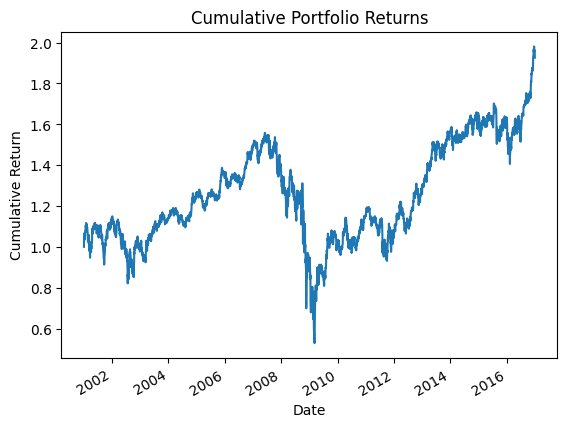

In [115]:
portfolio_weights = {'WMT': 0.2, 'IBM': 0.1, 'C': 0.3, 'MSFT': 0.1, 'GOOG': 0.1, 'DELL':0.2}

all_df['Daily Return'] = all_df.groupby('symbol')['Adj Close'].pct_change()

# Multiply returns by weights
all_df['Weighted Return'] = all_df['Daily Return'] * all_df['symbol'].map(portfolio_weights)

# Calculate portfolio return
portfolio_return = all_df.groupby(all_df.index)['Weighted Return'].sum()

# Calculate cumulative returns
cumulative_return = (1 + portfolio_return).cumprod()

# Plot cumulative returns
cumulative_return.plot(title='Cumulative Portfolio Returns', ylabel='Cumulative Return')


In [110]:
cumulative_return.tail()

Date
2016-12-23    0.960346
2016-12-27    0.962970
2016-12-28    0.942051
2016-12-29    0.934447
2016-12-30    0.926367
Name: Weighted Return, dtype: float64

How about monthly returns?

In [117]:
monthly = pd.DataFrame(portfolio_return, all_df.index)
# Change the index to only show the year and the month for grouping purposes
monthly.index = monthly.index.strftime('%Y-%m')
monthly.head()

retMonthly = monthly.groupby(monthly.index).sum()
retMonthly['Cumulative Return'] = (1+retMonthly['Weighted Return']).cumprod()-1
retMonthly




,Weighted Return,Cumulative Return
Date,,
2001-01,0.443334,0.443334
2001-02,-0.295025,0.017514
2001-03,-0.113058,-0.097524
2001-04,0.307841,0.180295
2001-05,0.058390,0.249213
...,...,...
2016-08,0.174085,-0.963488
2016-09,0.095610,-0.959997
2016-10,0.083238,-0.956667


<Axes: title={'center': 'Cumulative Portfolio Returns Monthly'}, xlabel='Date', ylabel='Cumulative Return'>

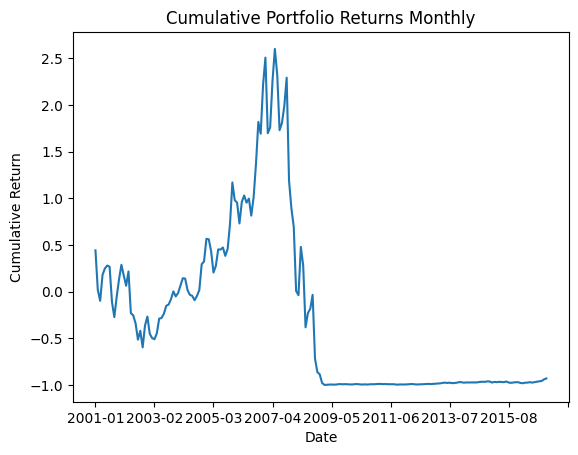

In [118]:
retMonthly['Cumulative Return'].plot(title='Cumulative Portfolio Returns Monthly', ylabel='Cumulative Return')